In [11]:
import scikit_posthocs as sp
import itertools

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/leiden/analysis/')
from clearmem_my_functions import *

from IPython.display import HTML, display

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

import pandas as pd
import numpy as np

def getF(data, var, group):
    data[var] = data[var].astype('float')
    model = ols(var + '~ C('+group+')', data=data).fit()
    anova_table = np.array(sm.stats.anova_lm(model, type=2)[['F', 'PR(>F)']])[0]
    return anova_table.round(4)

def getposthoc(data, var, group):
    data[var] = data[var].astype('float')
    model = ols(var + '~ C('+group+')', data=data).fit()
    post_hoc = sp.posthoc_ttest(data, val_col=var, group_col=group,
                                p_adjust='fdr_bh').sort_index().sort_index(axis = 1)
    post_hoc.columns = list(range(1, len(uni(data[group]))+1))
    return post_hoc

In [12]:
'''Specifically, the range of each gradient was calculated as the distance from the minimum to the maximum gradient
eigenvector values, and indicates a segregation (i.e. different conectivity profile) of the gradient extremes as 
well as an increased connectivity pattern within the extremes'''

'Specifically, the range of each gradient was calculated as the distance from the minimum to the maximum gradient\neigenvector values, and indicates a segregation (i.e. different conectivity profile) of the gradient extremes as \nwell as an increased connectivity pattern within the extremes'

In [13]:
from glob import glob

g1_paths = sorted(glob('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/*/*_g1_all_ops.csv', recursive = True))
g2_paths = sorted(glob('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/*/*_g2_all_ops.csv', recursive = True))
g3_paths = sorted(glob('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/*/*_g3_all_ops.csv', recursive = True))

In [14]:
def min_max_dist(data, x):
    dist = max(data[x]) - min(data[x])
    return dist

def get_grad_dist(path):

    all_subj_dist=[]
    for i in path:
        df = pd.read_csv(i)
        op_dist=[]
        for x in ['maintain', 'replace', 'suppress', 'clear']:
                op_dist.append(min_max_dist(df, x))
                
        op_dist = pd.DataFrame(op_dist).T
        op_dist['ID'] = df['sub'].str.replace('_sm_vector', '')
        all_subj_dist.append(op_dist)
    
    output = pd.concat(all_subj_dist)
    output.columns = ['maintain', 'replace', 'suppress', 'clear', 'ID']
    
    return output

g1_dist = get_grad_dist(g1_paths)
g2_dist = get_grad_dist(g2_paths)
g3_dist = get_grad_dist(g3_paths)

In [16]:
def regression(op, predictor):
    
    global g1_dist, g2_dist, g3_dist
    
    cent = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/predictions/centrality/'+op+'_cent_prediction.csv').iloc[:, 361:]
    
    if i == 'main':
        op = 'maintain'
        
    g1 = g1_dist[[op, 'ID']].rename({op:op+'_g1'}, axis=1)
    g2 = g2_dist[[op, 'ID']].rename({op:op+'_g2'}, axis=1)
    g3 = g3_dist[[op, 'ID']].rename({op:op+'_g3'}, axis=1)

    g = pd.merge(g1, g2, on ='ID')
    g = pd.merge(g, g3, on ='ID')
    g1_dists = pd.merge(g, cent, on = 'ID')


    # Initialise and fit linear regression model using `statsmodels`
    model = smf.ols(predictor + ' ~'+op+'_g1 +'+op+'_g2 +'+op+'_g3', data=g1_dists).fit()
    model_summary = model.summary()
    
    # convert our table to HTML and add colors to headers for explanatory purposes
    #HTML((model_summary
    #    .as_html()
    #    .replace('<th>  Adj. R-squared:    </th>', '<th style="background-color:#aec7e8;"> Adj. R-squared: </th>')
    #    .replace('<th>coef</th>', '<th style="background-color:#ffbb78;">coef</th>')
    #    .replace('<th>std err</th>', '<th style="background-color:#c7e9c0;">std err</th>')
    #    .replace('<th>P>|t|</th>', '<th style="background-color:#bcbddc;">P>|t|</th>')
    #    .replace('<th>[0.025</th>    <th>0.975]</th>', '<th style="background-color:#ff9896;">[0.025</th>    <th style="background-color:#ff9896;">0.975]</th>')))
    
    return model_summary  

In [17]:
accuracy_models = []
evidence_models = []

for i,j,k in zip(['main', 'replace', 'suppress', 'clear'],
                 ['t1_maintain_accuracy','t2_repCat_accuracy','t3_target_accuracy','t4_global_accuracy'],
                 ['t1_maintain_evidence','t2_repCat_evidence','t3_target_evidence','t4_global_evidence']):
    accuracy_models.append(regression(i,j))
    evidence_models.append(regression(i,k))


In [19]:
evidence_models

[<class 'statsmodels.iolib.summary.Summary'>
 """
                              OLS Regression Results                             
 Dep. Variable:     t1_maintain_evidence   R-squared:                       0.218
 Model:                              OLS   Adj. R-squared:                  0.171
 Method:                   Least Squares   F-statistic:                     4.645
 Date:                  Mon, 21 Nov 2022   Prob (F-statistic):            0.00610
 Time:                          12:52:47   Log-Likelihood:                 45.864
 No. Observations:                    54   AIC:                            -83.73
 Df Residuals:                        50   BIC:                            -75.77
 Df Model:                             3                                         
 Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------

In [18]:
accuracy_models

[<class 'statsmodels.iolib.summary.Summary'>
 """
                              OLS Regression Results                             
 Dep. Variable:     t1_maintain_accuracy   R-squared:                       0.236
 Model:                              OLS   Adj. R-squared:                  0.190
 Method:                   Least Squares   F-statistic:                     5.144
 Date:                  Mon, 21 Nov 2022   Prob (F-statistic):            0.00354
 Time:                          12:52:47   Log-Likelihood:                 29.209
 No. Observations:                    54   AIC:                            -50.42
 Df Residuals:                        50   BIC:                            -42.46
 Df Model:                             3                                         
 Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------

In [6]:
'''
The metrics were compared across states (WR, SD and PRN) using a repeated-measures linear model with post-hoc t-tests between states. 
Finally, the range of gradients were compared before and after applying GSR with paired-sample t-tests p<0.05.

To do:
Post-hoc tests with gradients, centraility, dispersion, gradient range across states
'''

'\nThe metrics were compared across states (WR, SD and PRN) using a repeated-measures linear model with post-hoc t-tests between states. \nFinally, the range of gradients were compared before and after applying GSR with paired-sample t-tests p<0.05.\n\nTo do:\nPost-hoc tests with gradients, centraility, dispersion, gradient range across states\n'

In [8]:
mg = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/main_grads.csv')
rg = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/replace_grads.csv')
sg = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/suppress_grads.csv')
cg = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/grp/clear_grads.csv')

g1s = pd.concat([mg['g3'], rg['g3'], sg['g3'], cg['g3']], axis=1)
g1s.columns = ['main', 'replace', 'suppress', 'clear']

g1s_long = g1s.melt()

In [10]:
'''
To assess the relationship between cognition and measures of network dispersion in the 3D gradient space (i.e. network level segregation),
we used a partial least squares (PLS) model. This was chosen over a linear regression model due to a) the number of predictors, and b)
the high collinearity between network dispersion metrics making them unsuitable for multiple linear regression. PLS analysis is a 
multivariate statistical technique that finds weighted patterns of variables in a predictor set (X) and response set (Y) to achieve 
maximum covariance across all variables (Krishnan et al., 2011; McIntosh and Lobaugh, 2004, McIntosh and Misic, 2013). 
We entered the range of the 3 gradients and dispersions of 17 functional networks in 3D gradient space into a Nx20 matrix X and 
the cognitive measures at the WR state (RT and accuracy for all three tasks) into a Nx6 matrix Y (where N is the number of subjects).
A covariance matrix was created from these two variable sets and subjected to singular value decomposition
'''

'\nTo assess the relationship between cognition and measures of network dispersion in the 3D gradient space (i.e. network level segregation),\nwe used a partial least squares (PLS) model. This was chosen over a linear regression model due to a) the number of predictors, and b)\nthe high collinearity between network dispersion metrics making them unsuitable for multiple linear regression. PLS analysis is a \nmultivariate statistical technique that finds weighted patterns of variables in a predictor set (X) and response set (Y) to achieve \nmaximum covariance across all variables (Krishnan et al., 2011; McIntosh and Lobaugh, 2004, McIntosh and Misic, 2013). \nWe entered the range of the 3 gradients and dispersions of 17 functional networks in 3D gradient space into a Nx20 matrix X and \nthe cognitive measures at the WR state (RT and accuracy for all three tasks) into a Nx6 matrix Y (where N is the number of subjects).\nA covariance matrix was created from these two variable sets and subj

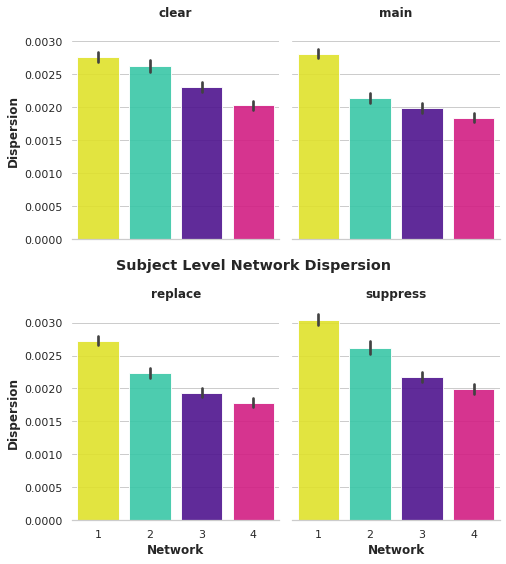

In [38]:
from glob import glob
disp_paths = sorted(glob('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/*_sm_vector/*_sm_vector_*_network_disp.csv', recursive = True))
disp_list=[]
for i in disp_paths:
    df = pd.read_csv(i)
    disp_list.append(df)
disp_subs = pd.concat(disp_list)

sns.set_theme(style="whitegrid")

g= sns.catplot(
    data=disp_subs, 
    x="Subtype", y="dispersion", col="op",
    kind="bar", 
    height=4, 
    aspect=.9, 
    hue = 'Subtype', 
    dodge=False,
    palette = ['#FCFF0D', '#21DFB4', '#4E00A2', '#F00087'],
    col_wrap =2,
    alpha = .9
)

(g.set_axis_labels("Network", "Dispersion",  weight='bold')
          .set_titles("{col_name}", weight='bold')
          .despine(left=True))

g.fig.suptitle('Subject Level Network Dispersion', weight='bold', y=0.54)
plt.subplots_adjust(hspace=0.3)

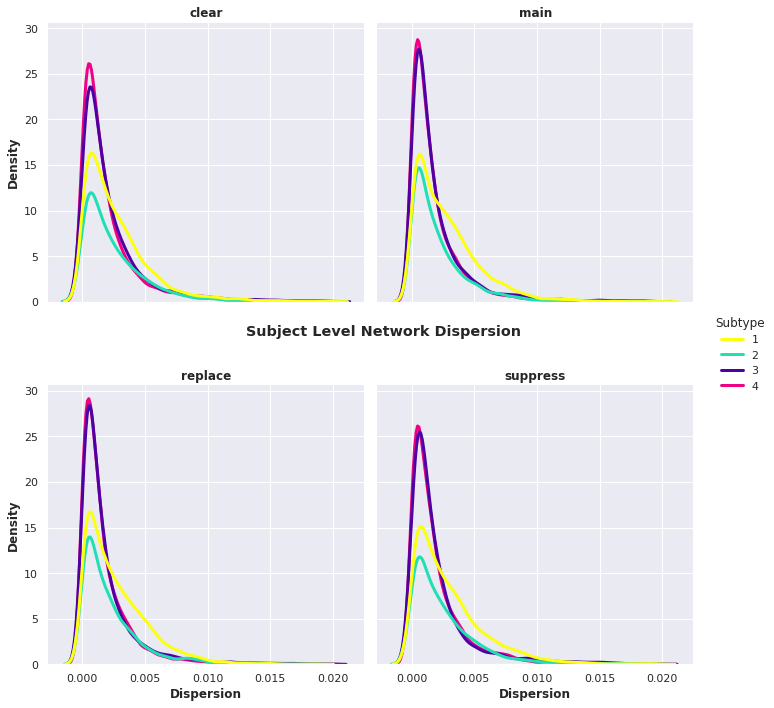

In [39]:
#disp_subs['dispersion_t'] = np.sqrt(disp_subs['dispersion'])

sns.set_theme(style="darkgrid")

g = sns.displot(data=disp_subs.reset_index(drop=True).query('dispersion < .02'), 
             x='dispersion', kind ='kde', hue = 'Subtype', col="op",
                linewidth=3,
                palette = ['#FCFF0D', '#21DFB4', '#4E00A2', '#F00087'],
            col_wrap=2
           )

(g.set_axis_labels("Dispersion", "Density",  weight='bold')
          .set_titles("{col_name}", weight='bold')
          .despine(left=True))

g.fig.suptitle('Subject Level Network Dispersion', weight='bold', y=0.54)
plt.subplots_adjust(hspace=0.3)

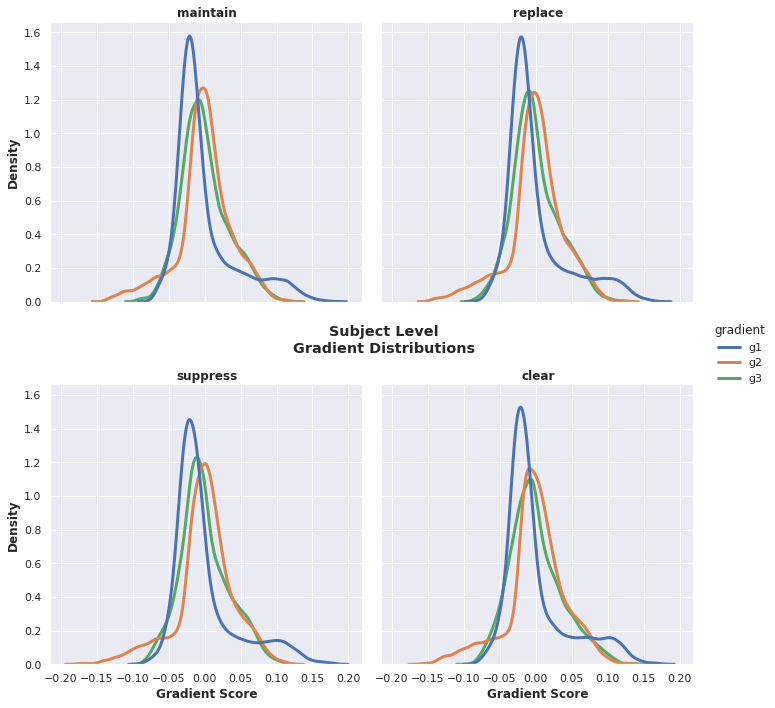

In [40]:
def get_sub_grads(path, grad):
    g_dens_list=[]
    for i in path:
        df = pd.read_csv(i)
        g_dens_list.append(df)
    g_dens_subs = pd.concat(g_dens_list)
    g_dens_subs_l = g_dens_subs.iloc[:,2:].melt(id_vars='sub').rename({'variable':'op'},axis=1)
    g_dens_subs_l['gradient'] = grad
    
    return g_dens_subs_l
    
from glob import glob
g1_dens_paths = sorted(glob('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/*_sm_vector/*_sm_vector_g1_all_ops.csv', recursive = True))
g2_dens_paths = sorted(glob('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/*_sm_vector/*_sm_vector_g2_all_ops.csv', recursive = True))
g3_dens_paths = sorted(glob('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/*_sm_vector/*_sm_vector_g3_all_ops.csv', recursive = True))

g_subs_dens = pd.concat([get_sub_grads(g1_dens_paths, 'g1'),
           get_sub_grads(g2_dens_paths, 'g2'),
           get_sub_grads(g3_dens_paths, 'g3')])

sns.set_theme(style="darkgrid")

g = sns.displot(data=g_subs_dens.reset_index(drop=True), 
             x="value", kind ='kde', hue = 'gradient', col="op",
                linewidth=3,
            col_wrap=2
           )

(g.set_axis_labels("Gradient Score", "Density",  weight='bold')
          .set_titles("{col_name}", weight='bold')
          .despine(left=True))

g.fig.suptitle('Subject Level\nGradient Distributions', weight='bold', y=0.54)
plt.subplots_adjust(hspace=0.3)

In [110]:
op_net_disp_out = []
op_net_disp_post = []
for i in ['main', 'replace', 'suppress', 'clear']:
    op_net_disp_out.append(pd.DataFrame(getF(disp_subs.query("op =="+"'" + i + "'"), 'dispersion', 'Subtype')).T.round(3))
    op_net_disp_post.append(pd.DataFrame(getposthoc(disp_subs.query("op =="+"'" + i + "'"), 'dispersion', 'Subtype')).round(3))
    
op_net_disp_out = pd.concat(op_net_disp_out)
op_net_disp_out['op'] = ['main', 'replace', 'suppress', 'clear']
op_net_disp_out.columns = ['F', 'p', 'op']
op_net_disp_out

,F,p,op
0,149.986,0.0,main
0,138.856,0.0,replace
0,133.150,0.0,suppress
0,66.938,0.0,clear


In [111]:
def diag(data, op):
    post = np.array(data)
    tril = np.triu_indices(len(data))
    post[tril] = np.nan
    post=pd.DataFrame(post).replace(np.nan, "")
    post = post.iloc[:, 0:3].loc[1:3]
    post['op'] = [op]*3
    post.columns =['VN', 'SMN', 'FPCN', 'op']
    post.index = ['SMN', 'FPCN', 'DMN']
    
    return post

main_post = diag(op_net_disp_post[0], 'main')
replace_post =  diag(op_net_disp_post[1], 'replace')
suppress_post = diag(op_net_disp_post[2], 'suppress')
clear_post = diag(op_net_disp_post[3], 'clear')

pd.concat([main_post, replace_post, suppress_post, clear_post])

,VN,SMN,FPCN,op
SMN,0.0,,,main
FPCN,0.0,0.005,,main
DMN,0.0,0.0,0.005,main
SMN,0.0,,,replace
FPCN,0.0,0.0,,replace
DMN,0.0,0.0,0.002,replace
SMN,0.0,,,suppress
FPCN,0.0,0.0,,suppress
DMN,0.0,0.0,0.002,suppress
SMN,0.029,,,clear


In [133]:
def pop_std(x):
    return x.std(ddof=0)

result = (
    disp_subs.groupby(['Subtype', 'op'], as_index=False)
    .agg({'dispersion':['mean',pop_std]})
    .rename({'pop_std':'std'}, axis=1)
)

def name_change(Subtype):
    if Subtype == 1:
        return 'VN'
    if Subtype == 2:
        return 'SMN'
    if Subtype == 3:
        return 'FPCN'
    if Subtype == 4:
        return 'DMN'


result["Subtype"] = result["Subtype"].map(lambda x: name_change(x))
result

Subtype        op dispersion          
                           mean       std
0       VN     clear   0.002761  0.002769
1       VN      main   0.002815  0.002625
2       VN   replace   0.002723  0.002536
3       VN  suppress   0.003042  0.003070
4      SMN     clear   0.002626  0.002895
5      SMN      main   0.002137  0.002320
6      SMN   replace   0.002231  0.002407
7      SMN  suppress   0.002614  0.002850
8     FPCN     clear   0.002308  0.002992
9     FPCN      main   0.001981  0.002664
10    FPCN   replace   0.001939  0.002679
11    FPCN  suppress   0.002170  0.003017
12     DMN     clear   0.002026  0.002792
13     DMN      main   0.001839  0.002482
14     DMN   replace   0.001784  0.002454
15     DMN  suppress   0.001994  0.002749

In [270]:
def create_subj_op_disp(data, subj, op):
    
    test = data.query('sub =='+ '"'+subj+'"'+ ' and op == '+ '"'+op+ '"')[['dispersion']].T

    new_cols = []
    for i in test.columns:
        new_cols.append('nd_'+str(i))

    test.columns = new_cols
    test['op'] = op
    test = test.reset_index(drop=True)
    #test['sub'] = subj

    return test
    
outs = []
    
for i in list(disp_subs['sub'].unique()): 
    for j in ['main', 'replace', 'suppress', 'clear']:
        
        outs.append(create_subj_op_disp(disp_subs, i, j))
        
dispersion_wide = pd.concat(outs)

main_dispersion_wide=dispersion_wide.query('op == "main"').drop('op', axis=1)
replace_dispersion_wide=dispersion_wide.query('op == "replace"').drop('op', axis=1)
suppress_dispersion_wide=dispersion_wide.query('op == "suppress"').drop('op', axis=1)
clear_dispersion_wide=dispersion_wide.query('op == "clear"').drop('op', axis=1)

main_dispersion_wide['g1_range'] = g1_dist['maintain']
main_dispersion_wide['g2_range'] = g2_dist['maintain']
main_dispersion_wide['g3_range'] = g3_dist['maintain']

replace_dispersion_wide['g1_range'] = g1_dist['replace']
replace_dispersion_wide['g2_range'] = g2_dist['replace']
replace_dispersion_wide['g3_range'] = g3_dist['replace']

suppress_dispersion_wide['g1_range'] = g1_dist['suppress']
suppress_dispersion_wide['g2_range'] = g2_dist['suppress']
suppress_dispersion_wide['g3_range'] = g3_dist['suppress']

clear_dispersion_wide['g1_range'] = g1_dist['clear']
clear_dispersion_wide['g2_range'] = g2_dist['clear']
clear_dispersion_wide['g3_range'] = g3_dist['clear']

In [288]:
for i,j in zip(['main', 'replace', 'suppress', 'clear'], 
               [main_dispersion_wide, replace_dispersion_wide,
                suppress_dispersion_wide, clear_dispersion_wide]):
    
    path_cent = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/predictions/centrality/'+i+'_cent_prediction.csv'

    df = pd.read_csv(path_cent).iloc[:, 1:]
    df_cents = df.iloc[:, 0:360]
    df_vars = df.iloc[:, 360:].iloc[:, [2,0,1]]
    
    df_con = pd.concat([df_cents, j.reset_index(drop=True)], axis=1)
    df_cents_with_disp = pd.concat([df_con, df_vars], axis=1)
    
    df_cents_with_disp.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/predictions/dispersion/'+i+'_cent_prediction_with_disp.csv')
    
    